# FloPy

### Zonbud Example 1

This notebook demonstrates how to use the functions included in the zonbud utility to extract budget information from the cell by cell budget file using an array of zones.

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import platform
import numpy as np
import matplotlib.pyplot as plt
from flopy.utils import ZoneBudget

# Set path to example datafiles
zbudpath = os.path.join('..', 'data', 'zonbud_examples')

### Create a ZoneBudget Object and Make Some Zones

We create a simple numpy integer-array to define some zones for which we are interested in getting cell-by-cell budget information.

In [2]:
# Create ZoneBudget object
cbc_file = os.path.join(zbudpath, 'freyberg.gitcbc')
zb = ZoneBudget(cbc_file)
print(zb.get_ssst_names())

['WELLS', 'RIVER LEAKAGE', 'RECHARGE']


In [3]:
print(zb.get_kstpkper())

[(0, 0)]


In [4]:
%%timeit
ZoneBudget(cbc_file)

1000 loops, best of 3: 1.65 ms per loop


In [5]:
# We can get the shape of the model from the ZoneBudget object
zb.get_model_shape()

(1L, 40L, 20L)

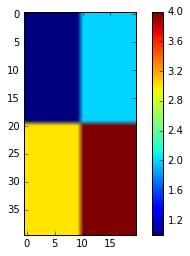

In [6]:
# Define some very interesting zones
nlay, nrow, ncol = zb.get_model_shape()
zon = np.zeros((nlay, nrow, ncol), np.int32)
zon[0, :nrow/2, :ncol/2] = 1
zon[0, :nrow/2, ncol/2:] = 2
zon[0, nrow/2:, :ncol/2] = 3
zon[0, nrow/2:, ncol/2:] = 4

im = plt.imshow(zon[0, :, :])
cbar = plt.colorbar(im)

### Extract Budget Information from ZoneBudget Object

We use the `get_budget()` method of the ZoneBudget object to return a Budget object, which is a thin wrapper around a numpy record array. The Budget object can be used to write the budget to a csv file. Let's look at the dtype:

In [7]:
bud = zb.get_budget(zon, kstpkper=(0, 0))
print(np.unique(zon))
print(bud.records.dtype)

[1 2 3 4]
[('flow_dir', 'S3'), ('record', 'S20'), ('ZONE 1', '<f4'), ('ZONE 2', '<f4'), ('ZONE 3', '<f4'), ('ZONE 4', '<f4')]


E:\local_repo\flopy_dev\flopy\flopy\utils\zonbud.py:323: UserWarning: Budget information for CONSTANT HEAD cells is not yet supported.Any non-zero results for CONSTANT HEAD andSWIADDTOCH should be considered erroneous.
  warnings.warn(chwarn, UserWarning)


In [8]:
print(bud.records)

[('in', 'WELLS', 0.0, 0.0, 0.0, 0.0)
 ('in', 'RIVER LEAKAGE', 0.0, 0.004194190260022879, 0.0, 0.0)
 ('in', 'RECHARGE', 0.01530000101774931, 0.020000001415610313, 0.01590000092983246, 0.018300000578165054)
 ('in', 'CONSTANT HEAD', 0.0, 0.0, 0.0, 0.0)
 ('in', 'FROM ZONE 1', 0.0, 0.013101870194077492, 0.0028348490595817566, 0.0)
 ('in', 'FROM ZONE 2', 0.0, 0.0, 0.0, 0.0012257143389433622)
 ('in', 'FROM ZONE 3', 0.0006367169553413987, 0.0, 0.0, 0.013000612147152424)
 ('in', 'FROM ZONE 4', 0.0, 0.0011461640242487192, 0.0, 0.0)
 ('out', 'WELLS', 0.0, 0.016199998557567596, 0.0015499999281018972, 0.00430000014603138)
 ('out', 'RIVER LEAKAGE', 0.0, 0.021016843616962433, 0.0, 0.025892717763781548)
 ('out', 'RECHARGE', 0.0, 0.0, 0.0, 0.0)
 ('out', 'CONSTANT HEAD', 0.0, 0.0, 0.0, 0.0)
 ('out', 'TO ZONE 1', 0.0, 0.0, 0.0006367169553413987, 0.0)
 ('out', 'TO ZONE 2', 0.013101870194077492, 0.0, 0.0, 0.0011461640242487192)
 ('out', 'TO ZONE 3', 0.0028348490595817566, 0.0, 0.0, 0.0)
 ('out', 'TO ZONE 4

In [9]:
print(bud.get_total_inflow())
print(bud.get_total_outflow())
print(bud.get_percent_error())

[ 0.01593672  0.03844223  0.01873485  0.03252633]
[ 0.01593672  0.03844256  0.01518733  0.03133888]
[ -1.16877591e-05  -8.52770929e-04   2.09156437e+01   3.71859360e+00]


In [10]:
%%timeit
zb.get_budget(zon, kstpkper=(0, 0))

100 loops, best of 3: 8.89 ms per loop


In [11]:
# Look at just the inflow terms:
print(bud.records[bud.records['flow_dir']=='in'])

[('in', 'WELLS', 0.0, 0.0, 0.0, 0.0)
 ('in', 'RIVER LEAKAGE', 0.0, 0.004194190260022879, 0.0, 0.0)
 ('in', 'RECHARGE', 0.01530000101774931, 0.020000001415610313, 0.01590000092983246, 0.018300000578165054)
 ('in', 'CONSTANT HEAD', 0.0, 0.0, 0.0, 0.0)
 ('in', 'FROM ZONE 1', 0.0, 0.013101870194077492, 0.0028348490595817566, 0.0)
 ('in', 'FROM ZONE 2', 0.0, 0.0, 0.0, 0.0012257143389433622)
 ('in', 'FROM ZONE 3', 0.0006367169553413987, 0.0, 0.0, 0.013000612147152424)
 ('in', 'FROM ZONE 4', 0.0, 0.0011461640242487192, 0.0, 0.0)]


In [12]:
# Look at just the recharge record
print(bud.records[bud.records['record']=='RECHARGE'])

[ ('in', 'RECHARGE', 0.01530000101774931, 0.020000001415610313, 0.01590000092983246, 0.018300000578165054)
 ('out', 'RECHARGE', 0.0, 0.0, 0.0, 0.0)]


In [13]:
# Look at outflow from zone 1
z1_outflow = bud.records['ZONE 1'][bud.records['flow_dir'] == 'out']
print(z1_outflow)
print('Total Outflow from Zone 1 (kstpkper=(0, 0)): {out:.5f}'.format(out=z1_outflow.sum()*-1))

[ 0.          0.          0.          0.          0.          0.01310187
  0.00283485  0.        ]
Total Outflow from Zone 1 (kstpkper=(0, 0)): -0.01594


In [14]:
# View the budget as a Pandas DataFrame
import pandas as pd
df = pd.DataFrame.from_records(bud.records)
df = df.set_index(['flow_dir', 'record']).sort_index()  # sort multi-index so we can slice it later
df

ZONE 1    ZONE 2    ZONE 3    ZONE 4
flow_dir record                                               
in       CONSTANT HEAD  0.000000  0.000000  0.000000  0.000000
         FROM ZONE 1    0.000000  0.013102  0.002835  0.000000
         FROM ZONE 2    0.000000  0.000000  0.000000  0.001226
         FROM ZONE 3    0.000637  0.000000  0.000000  0.013001
         FROM ZONE 4    0.000000  0.001146  0.000000  0.000000
         RECHARGE       0.015300  0.020000  0.015900  0.018300
         RIVER LEAKAGE  0.000000  0.004194  0.000000  0.000000
         WELLS          0.000000  0.000000  0.000000  0.000000
out      CONSTANT HEAD  0.000000  0.000000  0.000000  0.000000
         RECHARGE       0.000000  0.000000  0.000000  0.000000
         RIVER LEAKAGE  0.000000  0.021017  0.000000  0.025893
         TO ZONE 1      0.000000  0.000000  0.000637  0.000000
         TO ZONE 2      0.013102  0.000000  0.000000  0.001146
         TO ZONE 3      0.002835  0.000000  0.000000  0.000000
         TO ZONE 4      0.000000  0.001226  0.013001  0.000000
         WELLS          0.000000  0.016200  0.001550  0.004300

In [15]:
# Look at recharge in zones 3 and 4
df.loc[(['in'], ['RECHARGE']), ['ZONE 3', 'ZONE 4']].sum(axis=1)  # axis=1 to sum along rows

flow_dir  record  
in        RECHARGE    0.0342
dtype: float32

In [16]:
# Look at all outflow from zone 1
df.loc[(['out'], slice(None)), 'ZONE 1'].sum()

0.015936719

In [17]:
# Look at flow to zone 2
df.loc[(slice(None), ['TO ZONE 2']), :].sum(axis=1)  # axis=1 to sum along rows

flow_dir  record   
out       TO ZONE 2    0.014248
dtype: float32

### Write ZoneBudget Output to CSV

We can write the resulting recarray to a csv with the .to_csv() method of the ZoneBudget object.

In [18]:
out_fname = os.path.join(zbudpath, 'zbud.csv')
bud.to_csv(out_fname, write_format='pandas')

In [19]:
# Read the file in to see the contents
try:
    import pandas as pd
    df = pd.read_csv(out_fname)
    df = df.fillna(0)
    print(df.to_string(index=False))
except:
    with open(out_fname, 'r') as f:
        for line in f.readlines():
            print('\t'.join(line.split(',')))

flow_dir         record        ZONE 1        ZONE 2     ZONE 3    ZONE 4
     in          WELLS  0.000000e+00  0.000000e+00   0.000000  0.000000
     in  RIVER LEAKAGE  0.000000e+00  4.194190e-03   0.000000  0.000000
     in       RECHARGE  1.530000e-02  2.000000e-02   0.015900  0.018300
     in  CONSTANT HEAD  0.000000e+00  0.000000e+00   0.000000  0.000000
     in    FROM ZONE 1  0.000000e+00  1.310187e-02   0.002835  0.000000
     in    FROM ZONE 2  0.000000e+00  0.000000e+00   0.000000  0.001226
     in    FROM ZONE 3  6.367170e-04  0.000000e+00   0.000000  0.013001
     in    FROM ZONE 4  0.000000e+00  1.146164e-03   0.000000  0.000000
              Total IN  1.593672e-02  3.844223e-02   0.018735  0.032526
    out          WELLS  0.000000e+00  1.620000e-02   0.001550  0.004300
    out  RIVER LEAKAGE  0.000000e+00  2.101684e-02   0.000000  0.025893
    out       RECHARGE  0.000000e+00  0.000000e+00   0.000000  0.000000
    out  CONSTANT HEAD  0.000000e+00  0.000000e+00   0.000000  

### Plot Cell by Cell Budgets
Access and plot source/sink/storage budget terms.

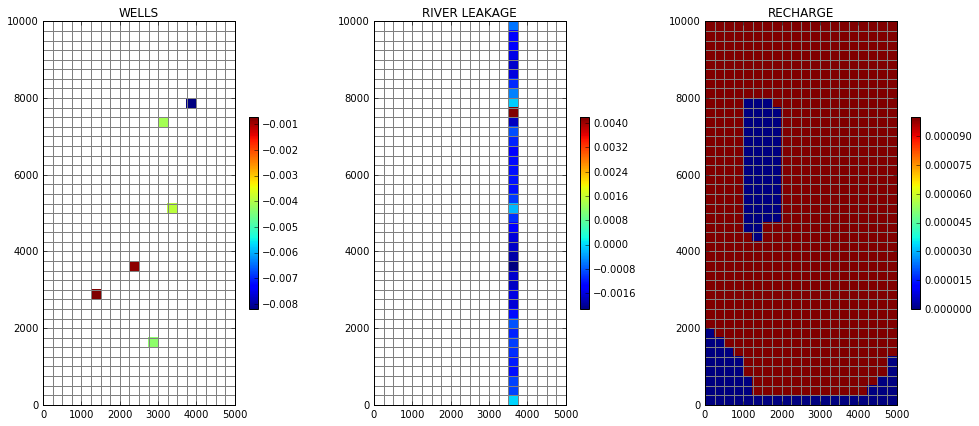

In [20]:
import flopy

nam_f = r'..\data\freyberg\freyberg.nam'
ml = flopy.modflow.Modflow.load(nam_f, check=False)

names = zb.get_ssst_names()
zbud_arrays = [zb.get_ssst_cbc_array(name, kstpkper=(0, 0)) for name in names]
fig = plt.figure(figsize=(14, 6))

for idx, name in enumerate(names):
    zbud = zbud_arrays[idx][0, :, :]
    ax = fig.add_subplot(1, len(names), idx+1, aspect='equal')
    ax.set_title(name)
    modelmap = flopy.plot.ModelMap(model=ml)
    modelmap.plot_grid()
    quadmesh = modelmap.plot_array(zbud)
    cbar = fig.colorbar(quadmesh, shrink=.5)

plt.tight_layout()
plt.show()